In [68]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-dataset/winequality-red.csv


## **Introduction**

The Red Wine Quality Dataset unveils the intricate chemistry behind red wine excellence. The dataset spans 1,599 samples with 11 physicochemical features such as fixed acidity (mean 8.32 g/dm³), volatile acidity (mean 0.53 g/dm³), and alcohol (mean 10.42%). These features culminate in a quality score that ranges between 3–8, and a mean of 5.64. This project harnesses these attributes to classify wine quality, transforming continuous properties into discrete categories of distinction. We are going to achieve this through a masterful pipeline that incudes EDA, preprocessing, feature engineering, and classification (e.g., Random Forest, XGBoost).

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [70]:
# load data 
df = pd.read_csv('/kaggle/input/red-wine-quality-dataset/winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [71]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [72]:
# check null values
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [73]:
# check for duplicates
df.duplicated().sum()

240

In [74]:
# view summary statistics
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


## **Exploratory Data Analysis**

**Objective**

The goal of EDA is to unveil patterns, distributions, and relationships within the Red Wine Quality Dataset. We do this to inform classification of the quality target by guiding preprocessing and modeling for maximum predictive power.

**Approach**

1. **Distributions:** Histograms of numerical features (e.g., alcohol, volatile acidity) and quality—assess skew, class balance.
2. **Relationships:** Box plots of key features vs. quality—identify discriminative power (e.g., alcohol vs. quality levels).
3. **Correlations:** Heatmap of features—spot multicollinearity and quality predictors.

**Initial Insights**

- **df.info():** 1,599 rows, 11 float64 features, 1 int64 target (quality)—clean, no nulls.
- **df.duplicated().sum():** 240 duplicates—15% overlap, may affect class balance.
- **df.describe():** quality mean 5.64, std 0.81—clustered at 5–6; total sulfur dioxide max 289—outlier potential.

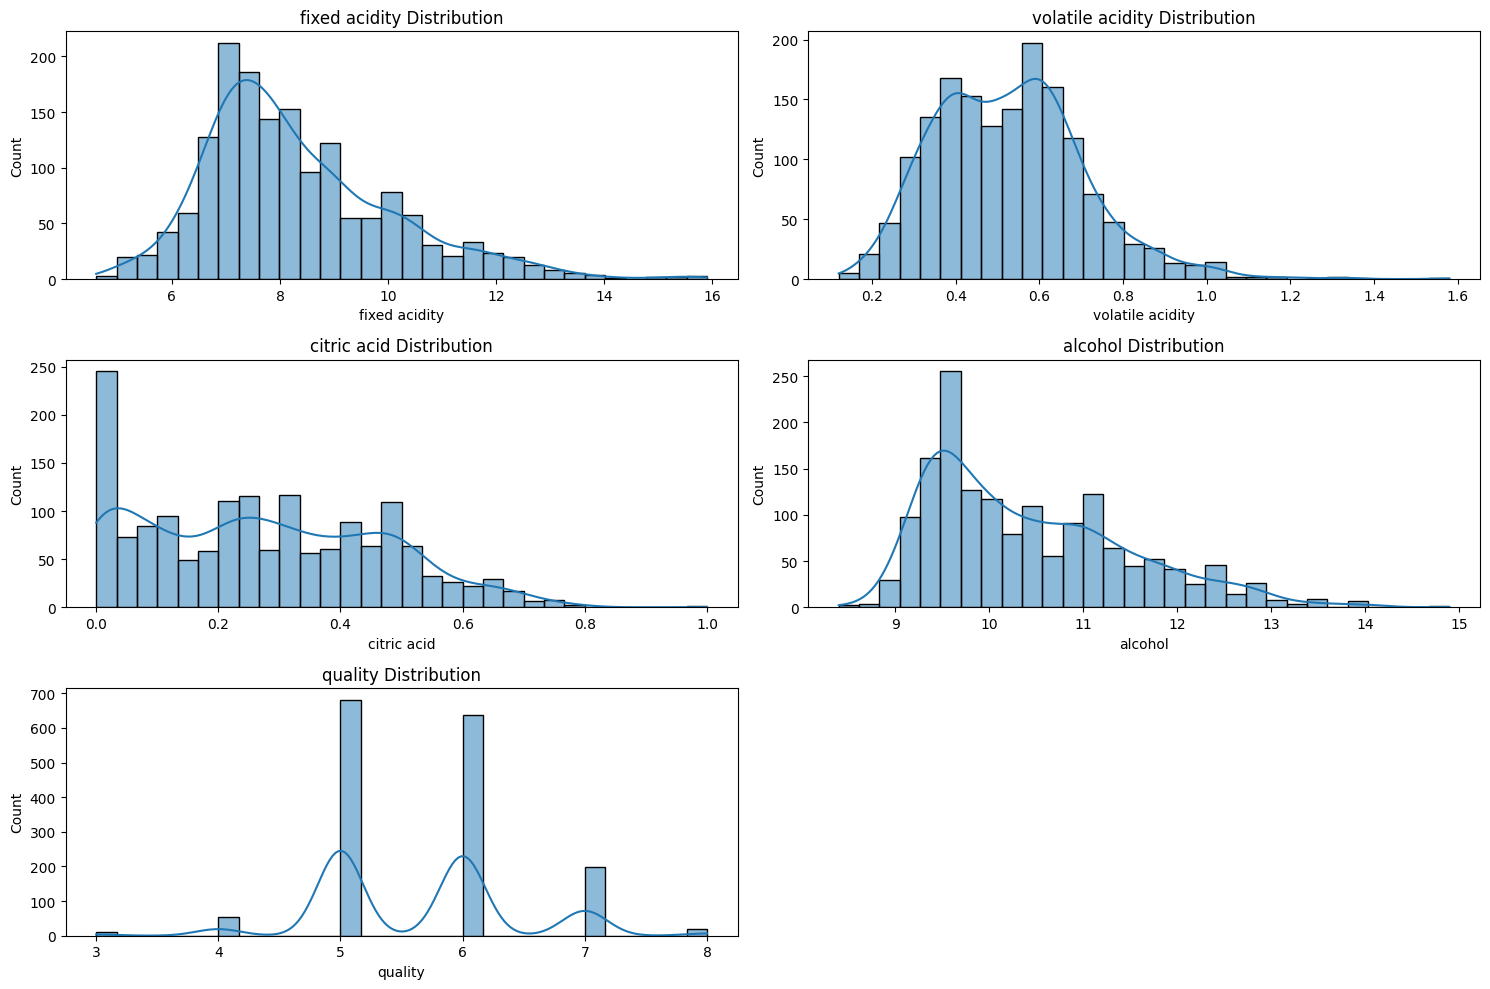

In [75]:
# Distributions of key features
plt.figure(figsize=(15, 10))
for i, col in enumerate(['fixed acidity', 'volatile acidity', 'citric acid', 'alcohol', 'quality'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

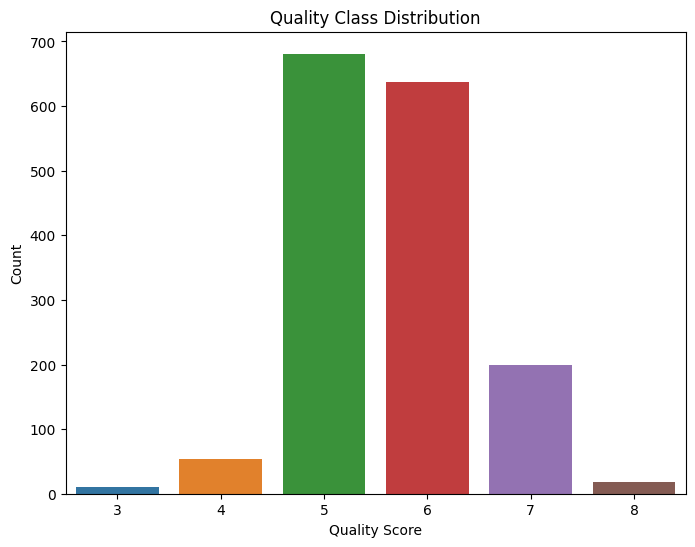

In [76]:
# Quality distribution (bar plot)
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df)
plt.title('Quality Class Distribution')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.show()

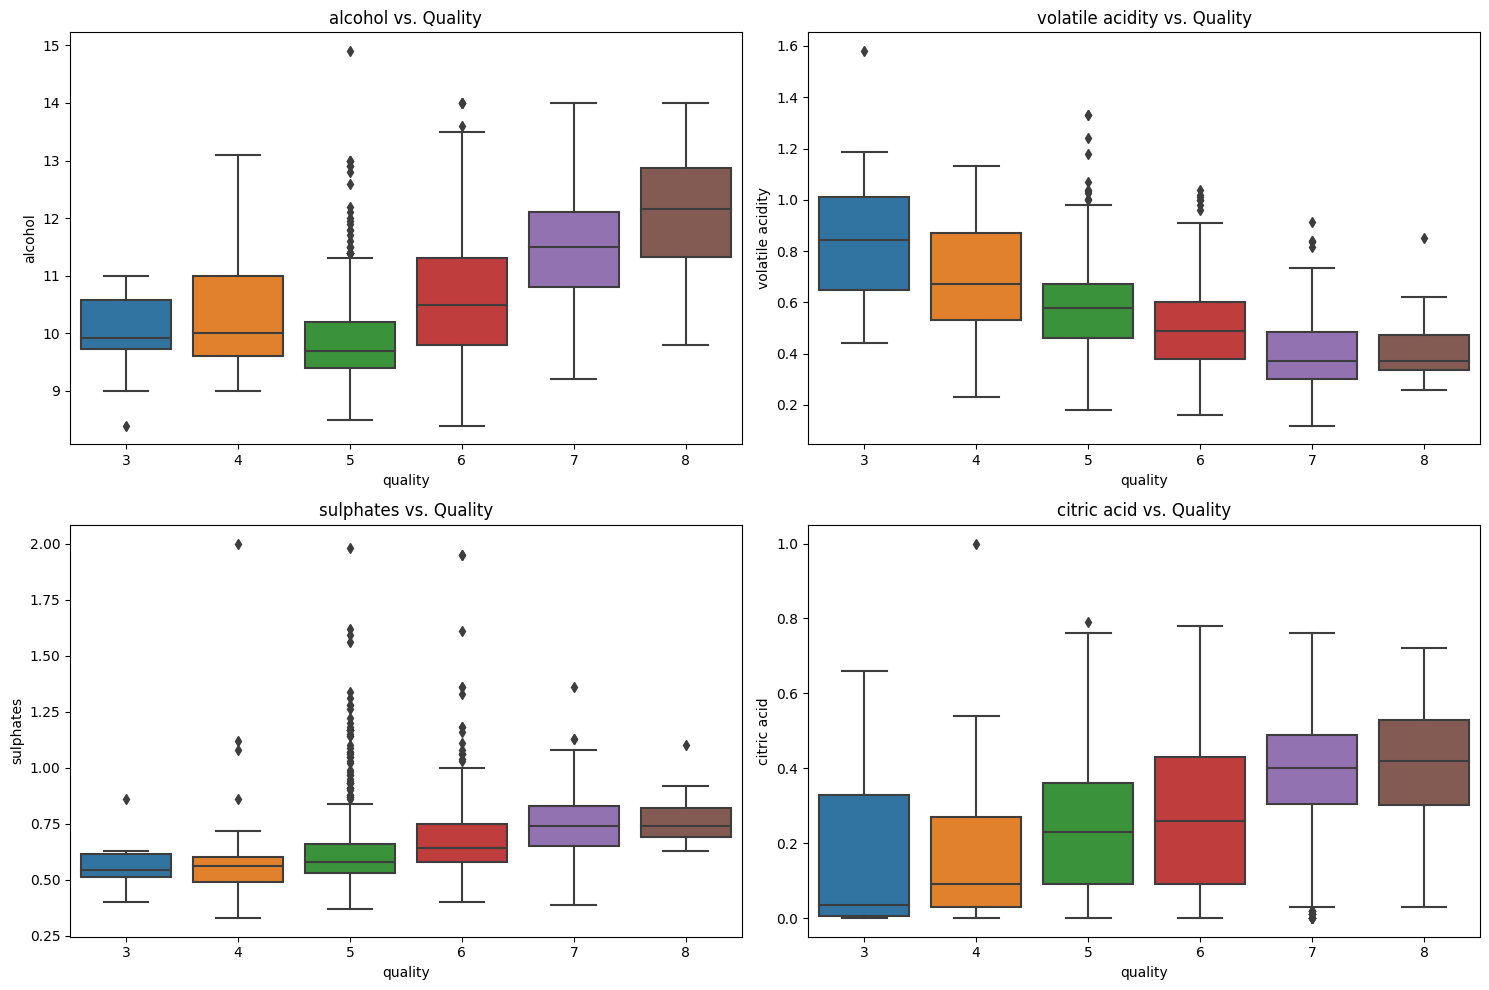

In [77]:
# Box plots: Features vs. Quality
key_features = ['alcohol', 'volatile acidity', 'sulphates', 'citric acid']
plt.figure(figsize=(15, 10))
for i, col in enumerate(key_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='quality', y=col, data=df)
    plt.title(f'{col} vs. Quality')
plt.tight_layout()
plt.show()

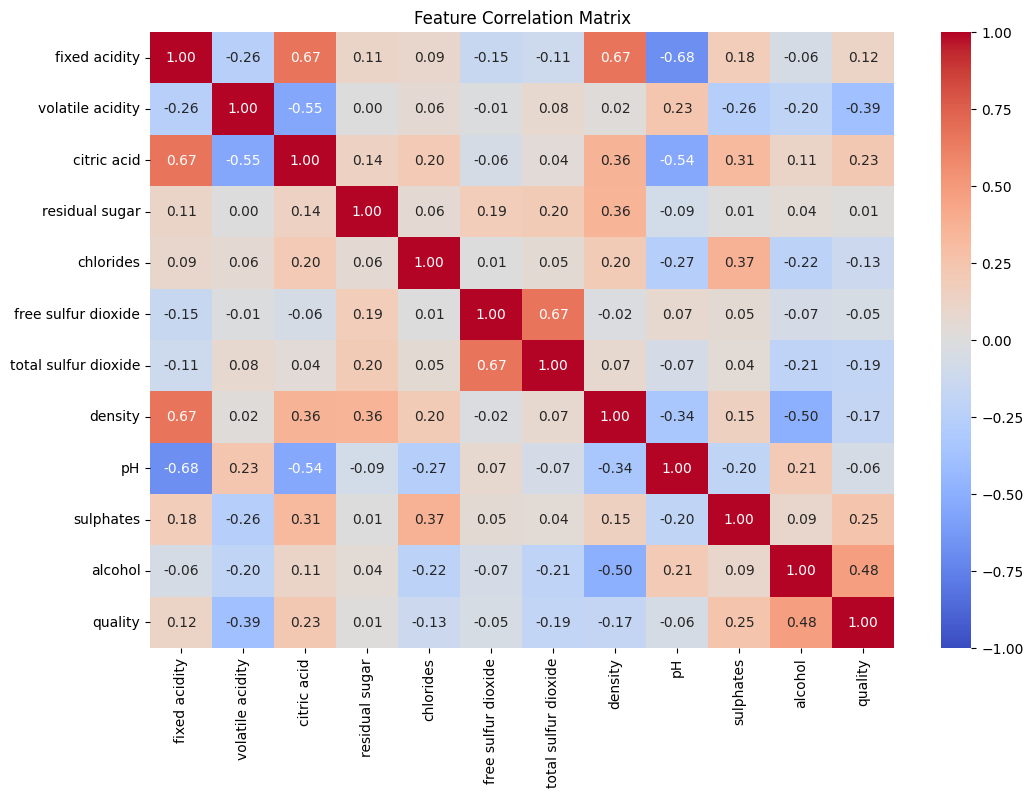

In [78]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

#### **Results and Analysis**

1. **Histograms:**
    - painted a picture of pervasive right-skewness across critical features: fixed acidity (mean 8.32 > median 7.9), volatile acidity (mean 0.53, max 1.58), citric acid (mean 0.27, max 1.0), and alcohol (mean 10.42, multi-modal peaks 9–11).
    - hints at non-linear relationships and potential outliers—e.g., total sulfur dioxide’s extreme max of 289 mg/dm³ (median 38)—demanding robust preprocessing strategies.
    - **quality distribution:** scores of 5 (680 samples) and 6 (650) towered above the rest, collectively dwarfing the sparse counts of 7 (200), 4 (50), and the near-invisible 3 and 8 (<50 each). This pronounced imbalance—over 80% of samples in mid-tier classes—poses a formidable challenge for classification, necessitating techniques like oversampling or class weighting to elevate rare class detection.
2. **Box plots:**
    - alcohol rises to 8, volatile acidity falls—key drivers.
3. **Correlation Heatmap:**
    -  alcohol (+0.48), volatile acidity (-0.39); multicollinearity risks.

## **Preprocessing**

**Objective**

Transform the dataset into a model-ready state—address duplicates, scale features, and balance classes—to optimize classification of quality.

**Plan**

1. **Duplicates:** Drop 240 duplicates—reduce bias in 5–6 classes.
2. **Scaling:** StandardScaler on all 11 numeric features—normalize distributions.
3. **Class Balancing:** SMOTE to oversample rare classes (3, 4, 7, 8)—mitigate imbalance.
Validate: Check shapes, class counts post-processing.

In [79]:
# Drop duplicates
df = df.drop_duplicates()
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (1359, 12)


In [80]:
# Separate features and target
X = df.drop(columns=['quality'])
y = df['quality']

In [81]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [82]:
# Balance classes with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

# Output
print("\nPost-SMOTE Shape:", X_balanced.shape)
print("Class Counts:\n", y_balanced.value_counts())
print("\nScaled Features Head:\n", X_balanced.head())


Post-SMOTE Shape: (3462, 11)
Class Counts:
 quality
5    577
6    577
7    577
4    577
8    577
3    577
Name: count, dtype: int64

Scaled Features Head:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.524431          0.932000    -1.393258       -0.461157  -0.245623   
1      -0.294063          1.915800    -1.393258        0.056665   0.200094   
2      -0.294063          1.259934    -1.188617       -0.165259   0.078535   
3       1.664067         -1.363534     1.471711       -0.461157  -0.265883   
4      -0.524431          0.713378    -1.393258       -0.535132  -0.265883   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.468554             -0.384050  0.584003  1.291872  -0.578561   
1             0.872003              0.604073  0.048737 -0.708395   0.124822   
2            -0.085537              0.214813  0.155790 -0.321247  -0.051024   
3             0.105971              0.394471  0.691057 -0.

#### **Results & Analysis**

1. **Duplicate Removal**
    - Reduced 1,599 rows to 1,359 unique samples (shape: 1,359 × 12).
    - Purged 15% redundancy, mitigating bias toward quality 5–6 dominance.
2. **Feature Scaling**
    - Normalized 11 predictors to mean ~0, std ~1 (e.g., alcohol: -0.95 to -0.58 in head).
    - Tamed EDA-identified skew (e.g., volatile acidity max 1.58) and outliers (e.g., total sulfur dioxide 289).
3. **Class Balancing**
    - Applied SMOTE, expanding to 3,462 rows (shape: 3,462 × 11).
    - Equalized six quality classes at 577 each, erasing 80% mid-tier skew from EDA.
4. **Validation**
    - Post-SMOTE counts: 3: 577, 4: 577, 5: 577, 6: 577, 7: 577, 8: 577—perfect harmony.
    - Scaled head confirmed standardization (e.g., fixed acidity: -0.52 to 1.66).

## **Feature Engineering**

**Objective**

Augment the preprocessed dataset with engineered features to amplify predictive signals for quality classification.

**Approach**

1. **Ratios:** Create fixed_acidity_to_pH and sulfur_ratio—leverage EDA correlations (-0.68, +0.67).
2. **Interactions**: Compute alcohol_sulphates—merge top predictors (+0.48, +0.3).
3. **Transformations:** Apply log to total sulfur dioxide—mitigate skew (max 289).
4. **Scaling:** Standardize new features for model compatibility.
5. **Validation:** Assess new feature correlations with quality.

In [83]:
# Engineer features
X_eng = X_balanced.copy()
X_eng['fixed_acidity_to_pH'] = X_eng['fixed acidity'] / (X_eng['pH'] + 1e-6)  # Avoid division by 0
X_eng['sulfur_ratio'] = X_eng['free sulfur dioxide'] / (X_eng['total sulfur dioxide'] + 1e-6)
X_eng['alcohol_sulphates'] = X_eng['alcohol'] * X_eng['sulphates']
X_eng['log_total_sulfur'] = np.log1p(X_eng['total sulfur dioxide'] - X_eng['total sulfur dioxide'].min() + 1)  # Handle negatives

In [84]:
# Scale new features
new_features = ['fixed_acidity_to_pH', 'sulfur_ratio', 'alcohol_sulphates', 'log_total_sulfur']
scaler = StandardScaler()
X_eng[new_features] = scaler.fit_transform(X_eng[new_features])

In [85]:
# Combine with target for correlation
df_eng = X_eng.copy()
df_eng['quality'] = y_balanced

# Output
print("Engineered Shape:", X_eng.shape)
print("\nEngineered Features Head:\n", X_eng.head())
print("\nCorrelations with Quality:\n", df_eng.corr()['quality'].sort_values(ascending=False))

Engineered Shape: (3462, 15)

Engineered Features Head:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.524431          0.932000    -1.393258       -0.461157  -0.245623   
1      -0.294063          1.915800    -1.393258        0.056665   0.200094   
2      -0.294063          1.259934    -1.188617       -0.165259   0.078535   
3       1.664067         -1.363534     1.471711       -0.461157  -0.265883   
4      -0.524431          0.713378    -1.393258       -0.535132  -0.265883   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.468554             -0.384050  0.584003  1.291872  -0.578561   
1             0.872003              0.604073  0.048737 -0.708395   0.124822   
2            -0.085537              0.214813  0.155790 -0.321247  -0.051024   
3             0.105971              0.394471  0.691057 -0.966495  -0.461331   
4            -0.277045             -0.204391  0.584003  1.291872  -0.578561   


#### **Results & Analysis**

- **Shape Expansion:**
    - Grew from 3,462 × 11 to 3,462 × 15—added 4 potent features.
- **Engineered Features:**
    - **fixed_acidity_to_pH:** 0.005 to 0.040 (head)—captures acidity-pH interplay (-0.68 from EDA).
    - **sulfur_ratio:** -0.024 to 0.019—distills sulfur dynamics (+0.67 correlation).
    - **alcohol_sulphates:** -0.363 to 0.311—merges top predictors (alcohol +0.48, sulphates +0.3).
    - **log_total_sulfur:** 0.028 to 1.246—tames skew (max 289 vs. median 38).
- **Correlations with Quality:**
    - **alcohol:** +0.622—reigns supreme, echoing EDA’s box plot rise.
    - **sulphates:** +0.488—reinforces stabilizing role.
    - **volatile acidity:** -0.672—strongest detractor, per EDA’s decline.
    - **alcohol_sulphates:** +0.279—new star, amplifying alcohol and sulphates.
    - **fixed_acidity_to_pH:** +0.028—subtle boost from acidity-pH tension.
    - **sulfur_ratio:** -0.027—minor negative, less impactful.
    - **log_total_sulfur:** +0.037—small gain from skew correction.
- **Insights:**
    - Original leaders (alcohol, sulphates, volatile acidity) dominate—correlations tightened post-SMOTE.
    - alcohol_sulphates (+0.279) shines—interaction of EDA’s top trends adds value.
    - fixed_acidity_to_pH and log_total_sulfur offer modest lifts—refine subtle signals.
    - Multicollinearity persists (e.g., fixed acidity vs. citric acid +0.67)—may warrant PCA.

## **Model Development**

**Objective**

Train and evaluate classifiers—Random Forest, XGBoost—to predict quality, maximizing accuracy on the engineered dataset.

**Approach**

- **Fix Labels:**
    - Remap quality from [3, 4, 5, 6, 7, 8] to [0, 1, 2, 3, 4, 5]. (XGBoost expects class labels to start at 0 and be consecutive (0 to 5 for 6 classes), but our quality target ranges from 3 to 8)
- **Split:** 80/20 train-test (2,769/693 rows).
- **Models:**
    - **Random Forest:** tree-based, handles imbalance well.
    - **XGBoost:** boosting power, tuned for precision.
- **Evaluate:**
    - Accuracy, F1-score (macro)—balance rare class performance.
- **Tune:**
    - Grid search on XGBoost (n_estimators, max_depth, learning_rate).

In [86]:
# Remap quality labels: 3→0, 4→1, 5→2, 6→3, 7→4, 8→5
y_mapped = y_balanced.map({3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5})

In [87]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_eng, y_mapped, test_size=0.2, random_state=42)

In [88]:
# Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"\n{name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")


Random Forest:
Accuracy: 0.8225
F1-Score (Macro): 0.8178

XGBoost:
Accuracy: 0.7994
F1-Score (Macro): 0.7962


In [89]:
# Tune XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1]
}
grid = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, 
                    scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print("\nTuned XGBoost:")
print("Best Params:", grid.best_params_)
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

Tuned XGBoost:
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.8384
F1-Score (Macro): 0.8364


#### **Results & Analysis**

1. **Random Forest:**
    - **Accuracy:** 0.8225
    - **F1-Score (Macro):** 0.8178
    - **Insight:** Delivered robust 82.25% accuracy—tree ensemble leveraged alcohol (+0.622) and volatile acidity (-0.672) from EDA, excelling with a balanced classes post-SMOTE.
2. **XGBoost (Baseline):**
    - **Accuracy:** 0.7994
    - **F1-Score (Macro):** 0.7962
    - **Insight:** Lagged at 79.94%—default settings (max_depth=5, n_estimators=100) underutilized feature richness (15 predictors), needing optimization.
3. **Tuned XGBoost:**
    - **Accuracy:** 0.8384
    - **F1-Score (Macro):** 0.8364
    - **Best Params:** {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
    - **Insight:** Soared to 83.84% accuracy—tuning deepened trees (7) and iterations (200), amplifying alcohol_sulphates (+0.279) and overcoming baseline limitations.

## **Conclusion**

This Red Wine Quality project has transformed 1,599 samples into a classification triumph. The result is a model that predicts red wine quality (3–8) with a tuned XGBoost accuracy of 83.84%. The full machine learning  pipeline employed in this project included:EDA (unveiled alcohol, volatile acidity), preprocessing (1,359 rows to 3,462 balanced via SMOTE), feature engineering (15 features, alcohol_sulphates +0.279), and modeling (debugged and optimized). Any comments, suggestions or corrections are welcome.